## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from skaro.planets import PlanetModel
from skaro.utilities.dataframe import rename_labels
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    contourplot,
    get_palette,
    set_plot_defaults,
)

## PLOT SETUP

In [4]:
set_plot_defaults()

figure_subdirectory = "Planet_model"
save = True

## REDUCING DIMENSIONALITY

In [5]:
num_samples = int(1e5)

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]
included_variables = ("log_initial_mass", "[Fe/H]")

### Creating Sample of included Monte Carlo Variables

In [6]:
bounds = {
    variable: planet_model.get_systems(population_id).bounds[variable]
    for variable in included_variables
}
samples = np.column_stack(
    [np.random.uniform(bound[0], bound[1], num_samples) for bound in bounds.values()]
)
samples = pd.DataFrame(samples, columns=bounds.keys())

### Compare behaviour of full and reduced model

In [7]:
prediction_parameter_dict = {
    "categories": categories,
    "host_star_mass": host_star_mass,
    "variables": samples,
    "return_full": False,
}

full_model_pred = planet_model.prediction(**prediction_parameter_dict)
reduced_model_pred = planet_model.prediction(
    **prediction_parameter_dict, included_variables=included_variables
)

In [8]:
full_model_pred.describe()

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.134412,3.400594,0.432667,0.113100,0.268439
std,2.060769,2.164790,0.430058,0.156951,0.423350
min,0.200000,0.000000,0.000000,0.000000,0.000000
25%,2.266667,1.300000,0.000000,0.000000,0.000000
50%,4.466667,3.566667,0.333333,0.000000,0.000000
75%,5.900000,5.333333,0.766667,0.233333,0.400000
max,8.833333,8.433333,2.100000,0.766667,1.666667


In [9]:
reduced_model_pred.describe()

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.904249,3.047936,0.430087,0.109260,0.306068
std,2.322470,2.585691,0.526632,0.185507,0.527782
min,0.566667,0.000000,0.000000,0.000000,0.000000
25%,1.500000,0.466667,0.000000,0.000000,0.000000
50%,3.933333,2.600000,0.233333,0.000000,0.000000
75%,6.100000,5.566667,0.700000,0.166667,0.400000
max,8.733333,8.166667,2.266667,0.933333,1.700000


## HYPERPARAMETER TUNING

In [10]:
# recreate original sample
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

In [11]:
# checking for optimal number of neighbors using k-fold cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

X = original_sample[list(included_variables)]
X_scaled = StandardScaler().fit_transform(X)
y = original_sample[categories]

# perform hyperparameter optimization using cross validation on data
hyperparameter_grid = {"n_neighbors": range(1, 101), "weights": ["uniform", "distance"]}

hp_search = GridSearchCV(
    KNeighborsRegressor(), hyperparameter_grid, cv=10
)  # Using 10-fold CV
hp_search.fit(X_scaled, y)

print(f"Best parameter: {hp_search.best_params_}")

Best parameter: {'n_neighbors': 39, 'weights': 'uniform'}


## MODEL BEHAVIOUR

In [12]:
num_bins = 140
included_variables = ("[Fe/H]", "log_initial_mass")

### Grid of Monte Carlo Variables

In [13]:
variable_grid = planet_model.get_systems(population_id).variable_grid(
    num_bins,
    included_variables=included_variables,
    as_dataframe=True,
)

grid_results = planet_model.prediction(
    categories,
    host_star_mass,
    variables=variable_grid,
    included_variables=included_variables,
    return_full=True,
)

grid_results = planet_model.calculate_solid_mass(grid_results, return_full=True)
# add column with sum of all planets
grid_results["Planet"] = grid_results[categories].sum(axis=1)

grid_results, variable_labels = rename_labels(grid_results)

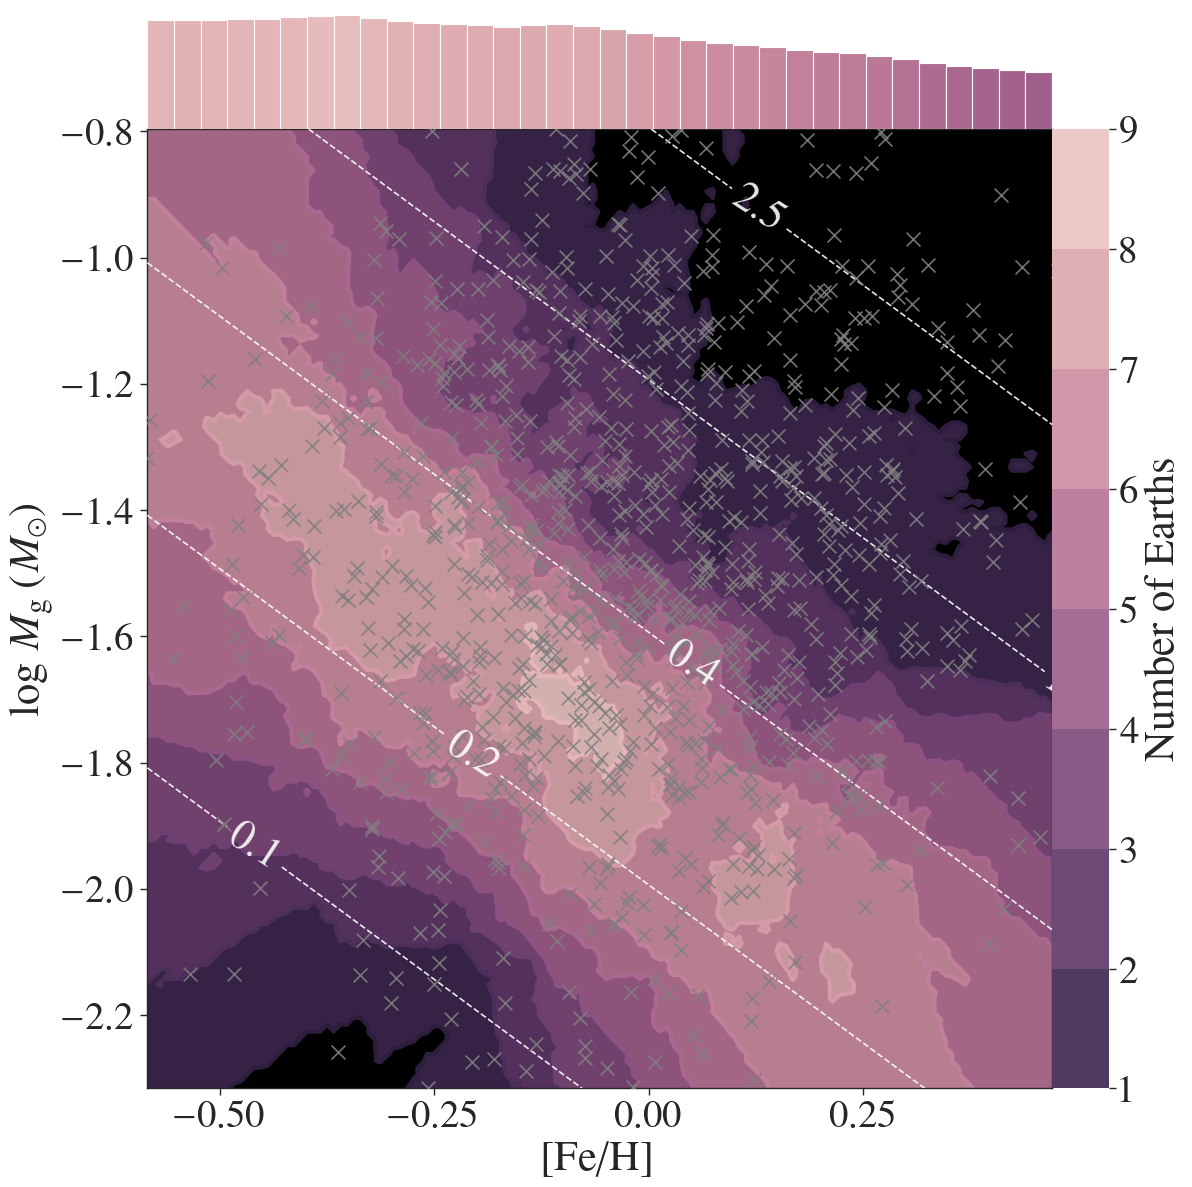

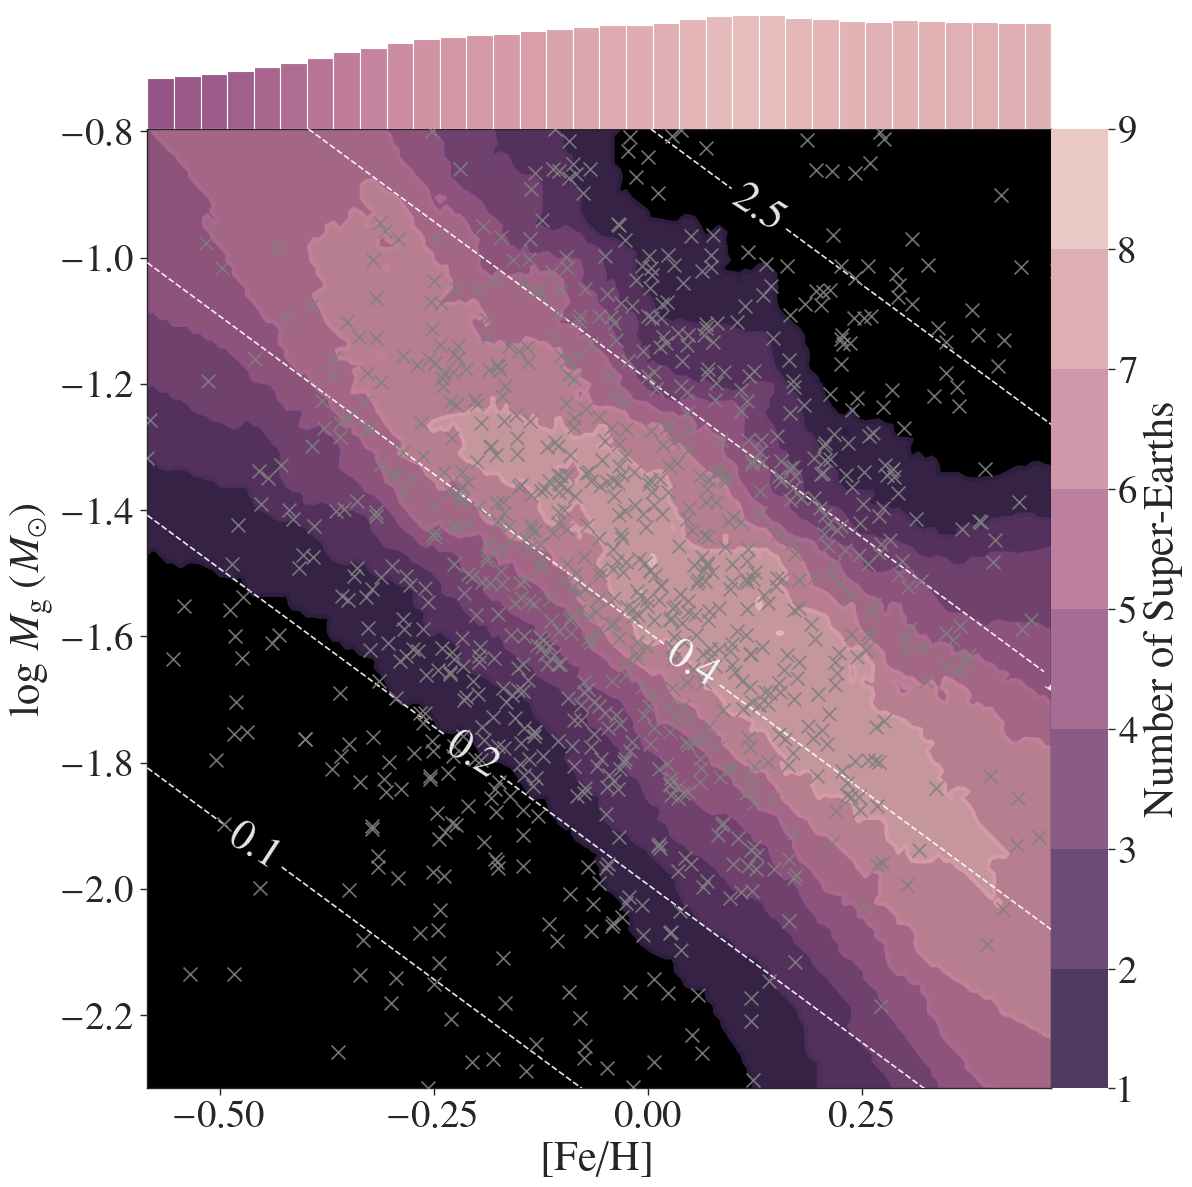

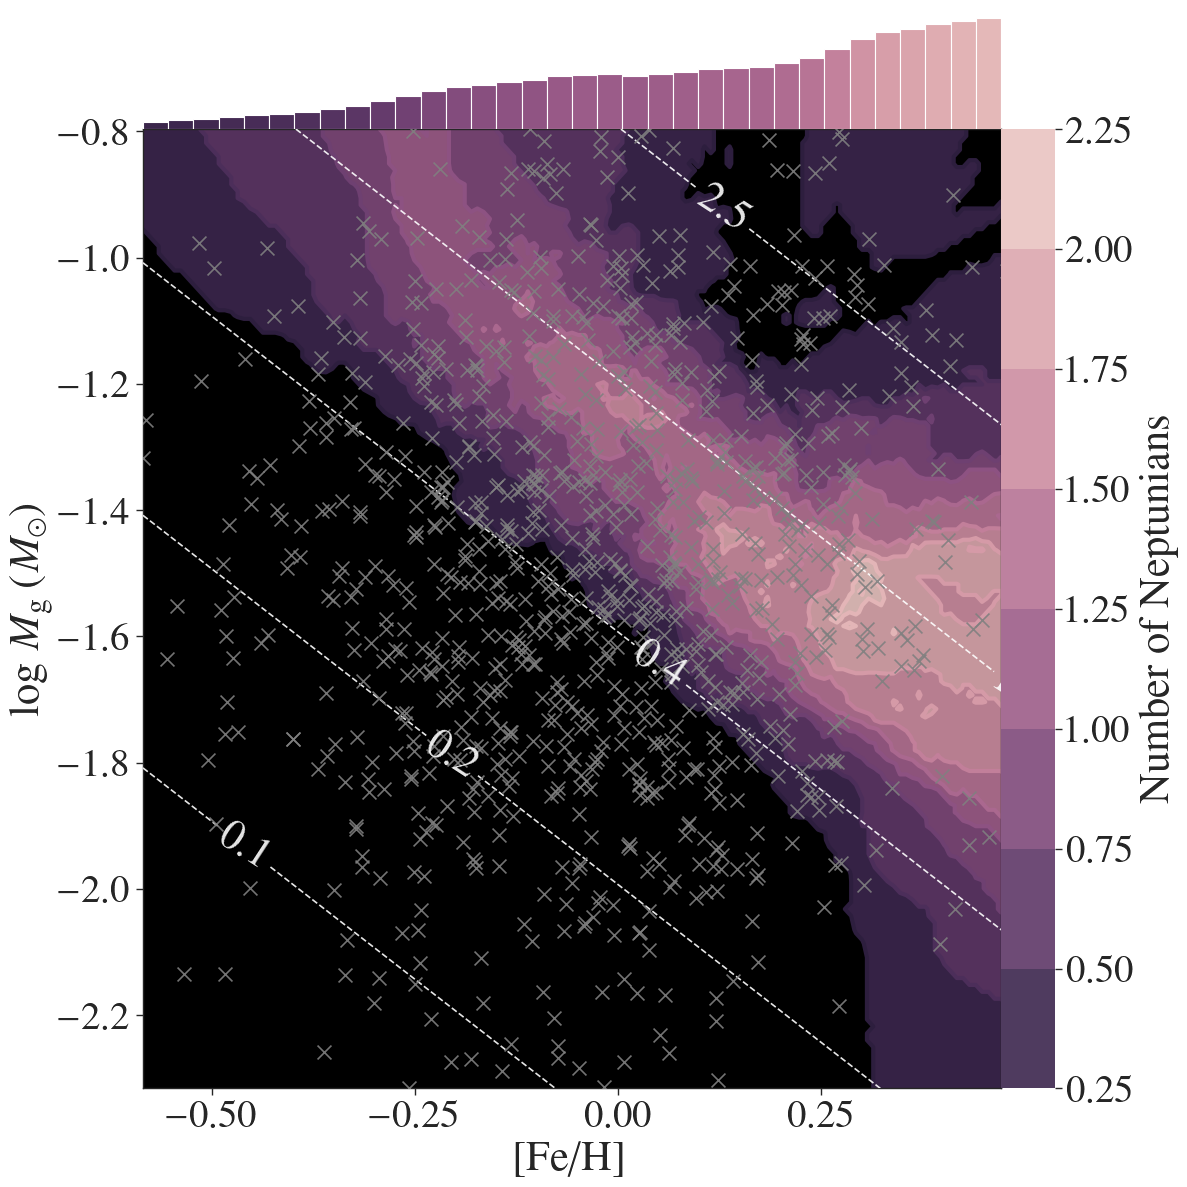

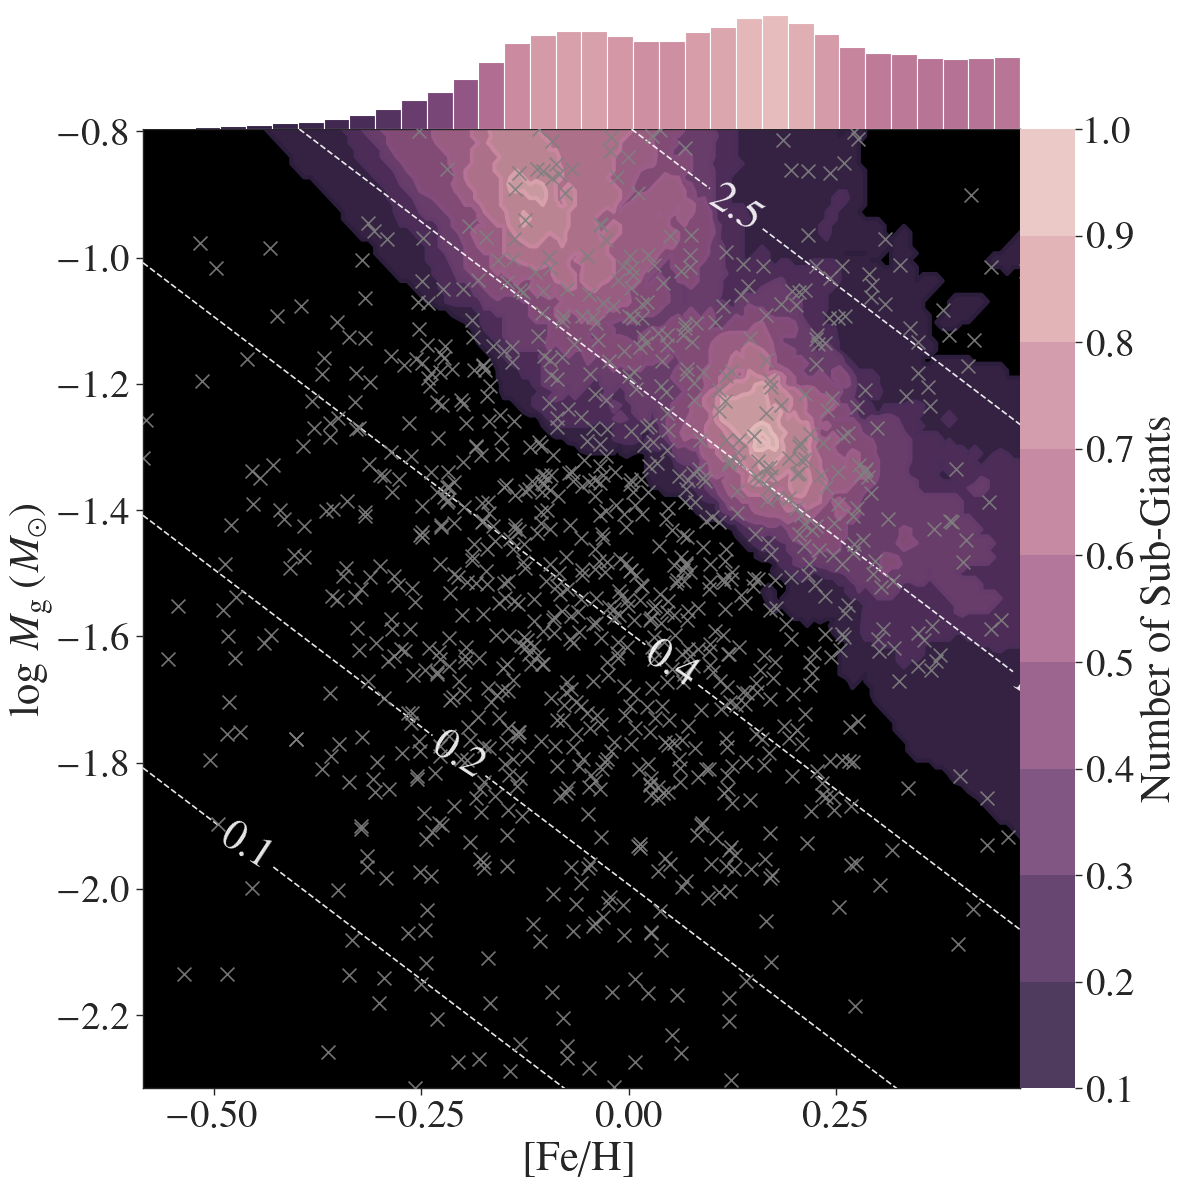

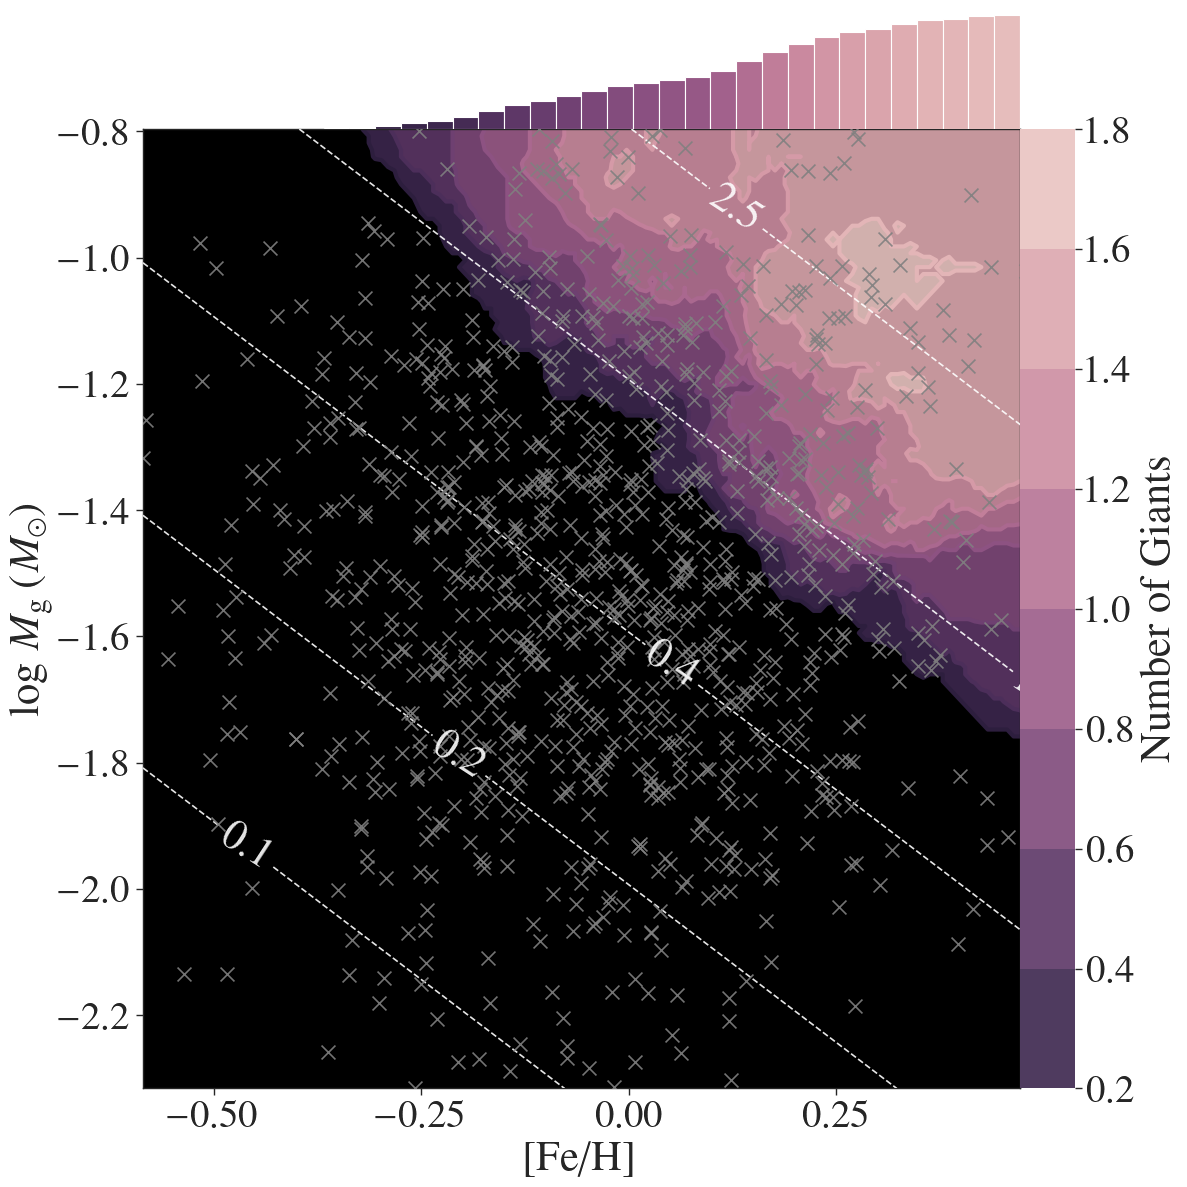

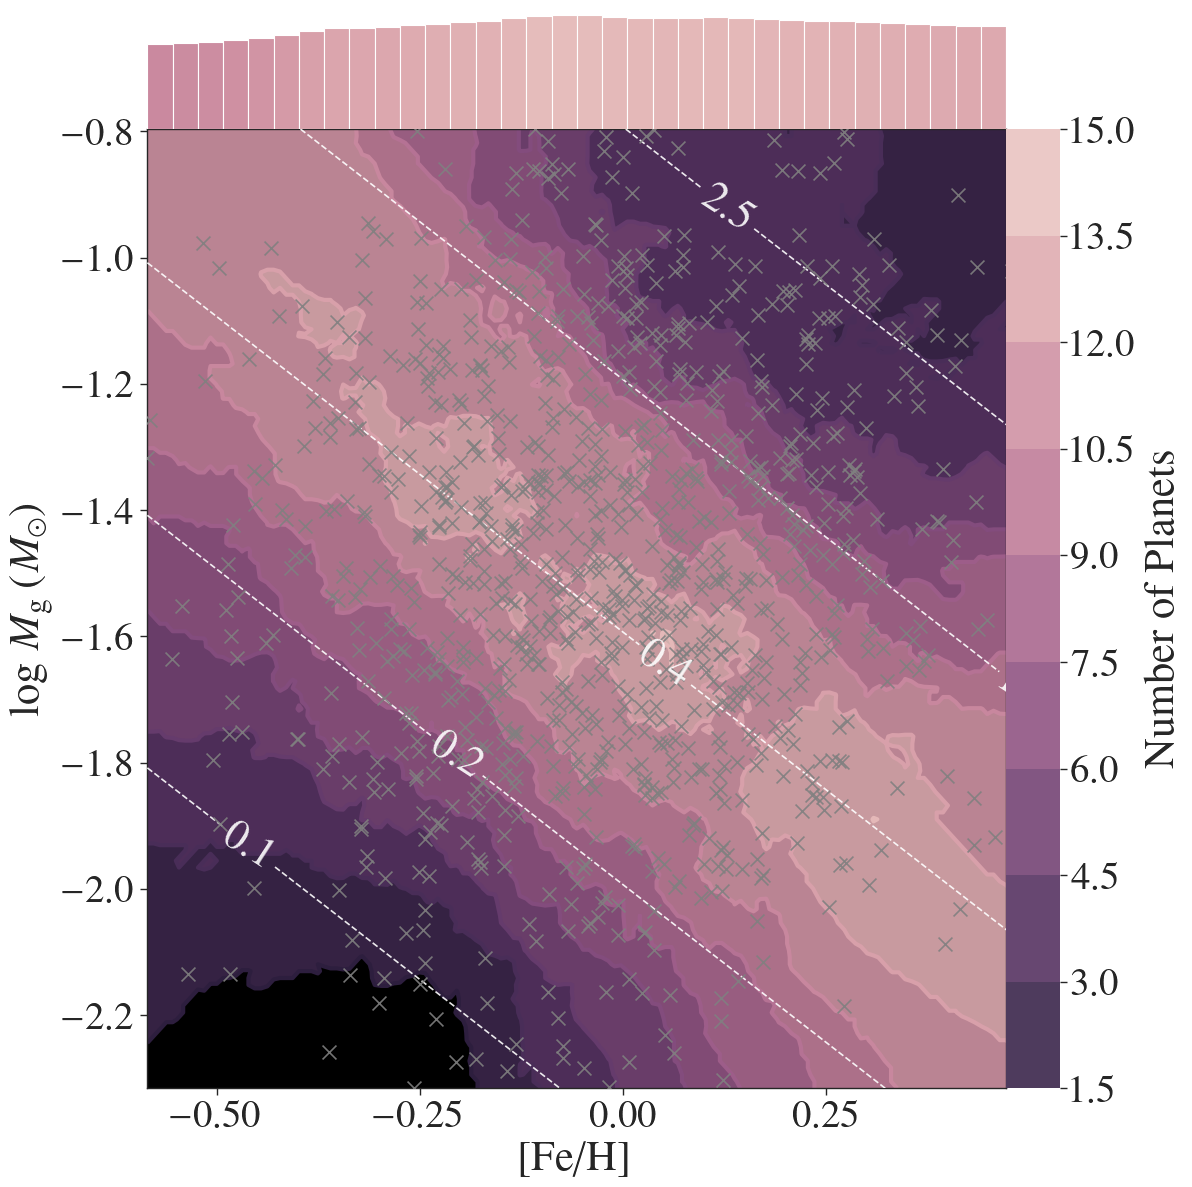

In [22]:
for category in categories + ["Planet"]:
    with sns.plotting_context("paper", font_scale=3.2):
        with sns.axes_style("ticks"):
            contour_plot, axes = contourplot(
                data=grid_results,
                x=variable_labels["[Fe/H]"],
                y=variable_labels["log_initial_mass"],
                hue=category,
                reshaping_bins=num_bins,
                bin_window=4,
                additional_contours=variable_labels["log_solid_mass"],
                cmap=get_palette(reverse=True, as_cmap=True),
                colorbar_label=f"Number of {category}s",
                square_aspect_ratio=True,
                outline=True,
                prune_lowest=True,
                contour_label_fmt=lambda log_solid_mass: "%1.1f" % (10**log_solid_mass),
                kws={"alpha": 0.9},
                okws={"linewidths": 3},
                ackws={
                    "levels": [-1.2, -0.8, -0.4, 0, 0.4],
                    "colors": "white",
                    "linestyles": "dashed",
                    "zorder": 9,
                    "alpha": 0.9,
                },
            )
            # add locations of original sample
            axes[0].scatter(
                x=original_sample["[Fe/H]"],
                y=original_sample["log_initial_mass"],
                color="grey",
                marker="x",
                alpha=0.9,
                s=100,
                zorder=10,
            )

    # save figure
    FigureProcessor(contour_plot.figure).save(
        f"contourplot_{category}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )